# Simulation et Monte Carlo

In [1]:
import numpy as np
import random as rd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from scipy.stats import vonmises

## Données angulaires 

Une loi classique pour des données correspondant à des angles observés sur l’intervalle [−π, π] est la loi de von Mises, de densité: $ π(θ) = \frac{1}{Z(κ)} exp(κ cos(θ − µ))$ où κ > 0, µ ∈ [−π, π], et Z(κ) est une constante de normalisation qui n’admet pas d’expression explicite. Cette loi est souvent qualifiée de loi normale pour les angles, car $cos(θ) ≈ 1 − θ^2$

### 1. Algorithme acceptation-rejet

In [2]:
def gen_uni_pi(n=1):
    return np.random.uniform(-np.pi, np.pi, n)

In [3]:
def unipi_density(x) :
    if x <= np.pi and x >= -np.pi:
        return 1/(2*np.pi)
    else:
        return 0
    
v_unipi_density = np.vectorize(unipi_density)

def von_mises_density(x, mu=0, kappa=1):
    return np.exp(kappa * np.cos(x - mu)) * (-np.pi <= x <= np.pi)

v_von_mises_density = np.vectorize(von_mises_density)

In [4]:
y = np.linspace(-np.pi, np.pi)

M = np.max(v_von_mises_density(y, mu=0, kappa=1)/v_unipi_density(y))

In [5]:
M

17.044412870709813

In [6]:
def von_mises_ra(M=M, mu=0, kappa=1):
    while True :
        x = gen_uni_pi()
        u = rd.random()
        if u <= (1/M)*von_mises_density(x)/(unipi_density(x)):
            return x 

C:\Users\elisa\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(-3.141592653589793, 3.141592653589793)

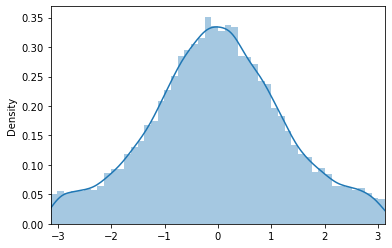

In [7]:
sns.distplot([von_mises_ra() for i in range(20_000)])
plt.xlim(-np.pi, np.pi)

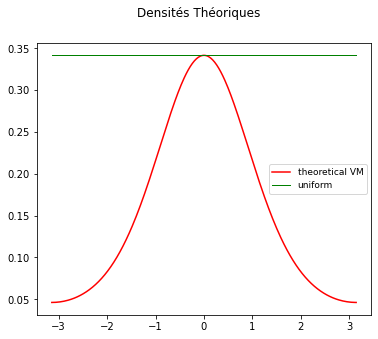

In [21]:
x = np.linspace(-np.pi, np.pi, 300)
fig, ax = plt.subplots(1,1, figsize=(6,5))
ax.plot(x, vonmises.pdf(x, kappa, mu), 'r-', label='theoretical VM')
ax.plot([-np.pi, np.pi], 2*[vonmises.pdf(x, kappa, mu).max()], 'g-', lw=1, label='uniform')
fig.suptitle('Densités Théoriques')
plt.legend(prop={'size': 9})
plt.show()
fig.savefig('Densites_Théoriques')

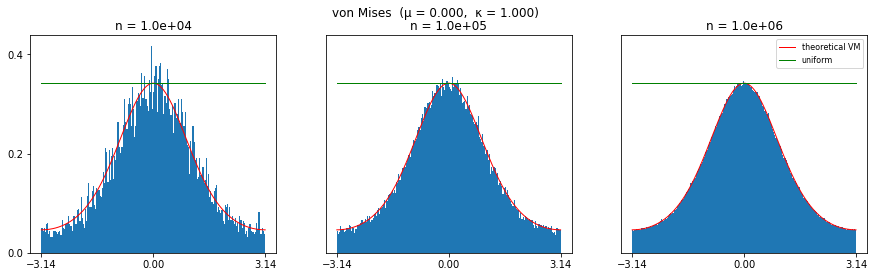

In [8]:
 n = [10_000, 100_000, 1_000_000]
mu = 0
kappa = 1 

# Plot 3 figures with different number of iterations of the simulation 

x = np.linspace(-np.pi, np.pi, 300)
fig, ax = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
i = 0

for nb in n:
    
    M = np.max(v_von_mises_density(x, mu=0, kappa=1)/v_unipi_density(x))
    
    res = [von_mises_ra(M,kappa,mu)[0] for i in range(nb)]
    
    ax[i].hist(res, bins=200, density=True)
    
    ax[i].plot(x, vonmises.pdf(x, kappa, mu), 'r-', lw=1, label='theoretical VM')

    ax[i].plot([-np.pi, np.pi], 2*[vonmises.pdf(x, kappa, mu).max()], 'g-', lw=1, label='uniform')

    ax[i].set_ylim([0., None])
    ax[i].set_xticks([-3.14, 0., 3.14])
    ax[i].title.set_text(f'n = {nb:.1e}')
    
    i += 1

ax[0].locator_params(axis="y", nbins=4)
ax[1].get_yaxis().set_visible(False)
ax[2].get_yaxis().set_visible(False)

fig.suptitle(f'von Mises  (\u03BC = {mu:.3f},  \u03BA = {kappa:.3f})')
plt.legend(prop={'size': 8})
plt.show()

### Performance en fonction de kappa et mu

In [22]:
# Return acceptance rate 

def acceptance_rate_ra_uniform(kappa=1, mu=0,  n=100_000):
    data = gen_uni_pi(n=n)
    data = data - mu
    val = np.exp(kappa * (np.cos(data) - 1))
    von_mises = data[np.random.uniform(0, 1, n) <= val] 
    return 100 * von_mises.shape[0] / n

In [23]:
acceptance_rate_ra_uniform(kappa=1, n= 100000)

46.794

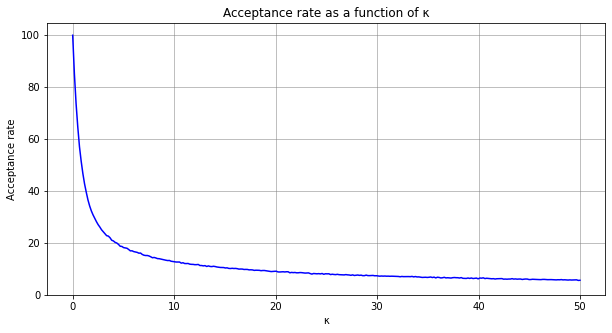

In [24]:
# Plot acceptance rate as a function of kappa

kappa = np.linspace(0, 50, 300)
n = 100000

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(kappa, [acceptance_rate_ra_uniform(kappa=i, n=n) for i in kappa], 'b-')
ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.grid(True, linewidth=0.5, color='grey', linestyle='-')
ax.set_xlabel("\u03BA")
ax.set_ylabel("Acceptance rate")
ax.set_title("Acceptance rate as a function of \u03BA")
plt.show()
fig.savefig('AR_kappa')

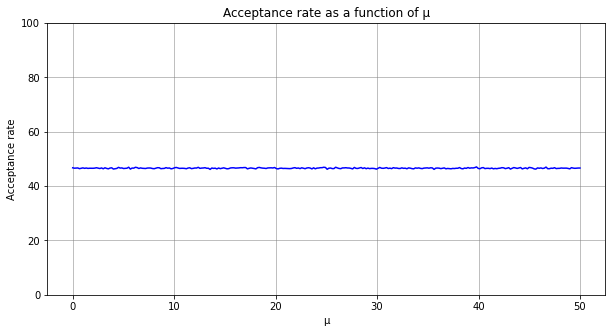

In [25]:
# Plot acceptance rate as a function of mu

kappa1 = 1
mu = np.linspace(0, 50, 300)
n = 100_000

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(kappa, [acceptance_rate_ra_uniform(kappa1, mu=i,n=n) for i in mu], 'b-')
ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.grid(True, linewidth=0.5, color='grey', linestyle='-')
ax.set_xlabel("\u03BC")
ax.set_ylabel("Acceptance rate")
ax.set_title("Acceptance rate as a function of \u03BC")
plt.show()
fig.savefig('AR_mu')

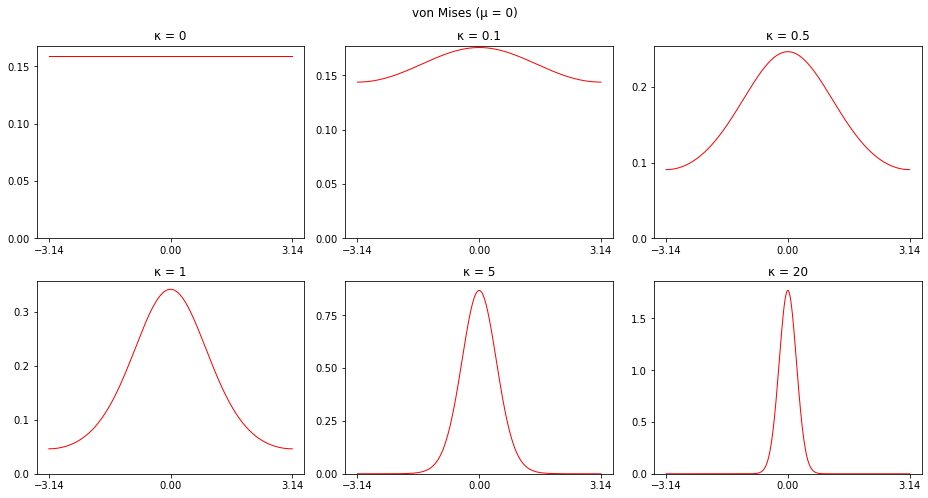

In [39]:
# Plot von Mises for different values of kappa

mu = 0
kappa = [0, 0.1, 0.5, 1, 5, 20]
x = np.linspace(-np.pi, np.pi, 300)

fig, ax = plt.subplots(2, 3, figsize=(13, 7))
i = 1

ax[0, 0].plot([-np.pi, np.pi], 2 * [1 / (2 * np.pi)], 'r-', lw=1)
ax[0, 0].set_ylim([0., None])
ax[0, 0].set_xticks([-3.14, 0., 3.14])
ax[0, 0].locator_params(axis="y", nbins=4)
ax[0, 0].title.set_text(f'\u03BA = {0}')

for val in kappa:
    if val != 0:
        ax[i // 3, i % 3].plot(x, vonmises.pdf(x, val, 0.), 'r-', lw=1)
        ax[i // 3, i % 3].set_ylim([0., None])
        ax[i // 3, i % 3].set_xticks([-3.14, 0., 3.14])
        ax[i // 3, i % 3].locator_params(axis="y", nbins=4)
        ax[i // 3, i % 3].title.set_text(f'\u03BA = {val}')
        i += 1

fig.suptitle('von Mises (\u03BC = 0)')
fig.tight_layout(pad=1.0)
plt.show()

#fig.savefig('Von_Mises_kappa.png')

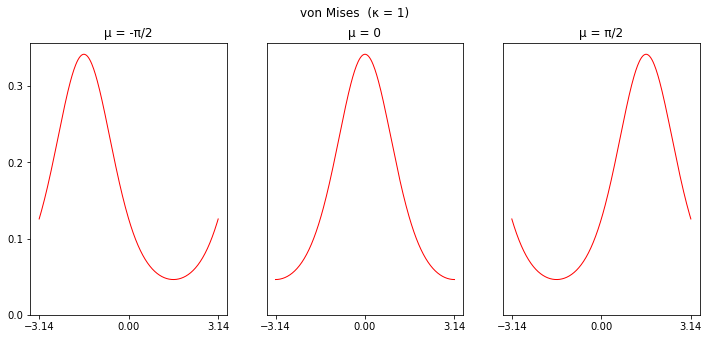

In [40]:
# Plot von Mises for different values of mu

kappa = 1
mu = [-np.pi / 2, 0, np.pi / 2]
x = np.linspace(-np.pi, np.pi, 300)

fig, ax = plt.subplots(1, 3, figsize=(12, 5), sharey=True)
i = 0

for val in mu:
    ax[i].plot(x, vonmises.pdf(x, kappa, val), 'r-', lw=1)
    ax[i].set_ylim([0., None])
    ax[i].set_xticks([-3.14, 0., 3.14])
    i += 1

ax[0].title.set_text(f'\u03BC = -\u03C0/2')
ax[1].title.set_text(f'\u03BC = 0')
ax[2].title.set_text(f'\u03BC = \u03C0/2')

ax[0].locator_params(axis="y", nbins=4)
ax[1].get_yaxis().set_visible(False)
ax[2].get_yaxis().set_visible(False)

fig.suptitle(f'von Mises  (\u03BA = 1)')
plt.show()

#fig.savefig('Von_Mises_mu.png')

### 2. Algorithme de Metropolis

Proposer un algorithme de Metropolis simple pour simuler selon une telle loi; notamment proposer une règle simple pour que 
la performance de l’algorithme ne dépende pas des paramètres. 
(Expliquer ce que veut dire le mot “performance” pour un tel algorithme.)

Contrairement à l'algorithme de rejet, MCMC crée des va qui ne sont pas indépendantes les unes des autres

In [31]:
def metropolis(x, sig= 3, mu=0, kappa=1):
    y = x + sig * np.random.randn()
    r = von_mises_density(y, mu, kappa) / von_mises_density(x, mu, kappa)
    if np.random.rand() < r:
        return (y,1) 
    else:
        return (x,0)

In [37]:
def simulation_metropolis(sig, kappa=1, mu=0,  N=100_000):
    x = np.zeros(N)
    for i in range(1,N):
        res = metropolis(x[i-1], sig, mu, kappa)
        x[i] = res[0]
    #plt.plot(x)
    sns.distplot(x)

In [33]:
def acceptance_rate_metropolis(sig, kappa=1, mu=0,  N=100_000):
    N_acceptance = 0
    x = np.zeros((N,2))
    for i in range(1,N):
        res = metropolis(x[i-1][0], sig, mu, kappa)
        x[i][0] = res[0]
    N_acceptance += res[1]
    return N_acceptance/N

In [50]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(kappa, [acceptance_rate_metropolis(sig, kappa=1, mu=0,  N=100_000) for sig in np.linspace(0.1, 20, 1000)], 'b-')
ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.grid(True, linewidth=0.5, color='grey', linestyle='-')
ax.set_xlabel("\u03BC")
ax.set_ylabel("Acceptance rate")
ax.set_title("Acceptance rate as a function of \u03BC")
plt.show()
#plt.savefig('AR_mu')

C:\Users\elisa\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


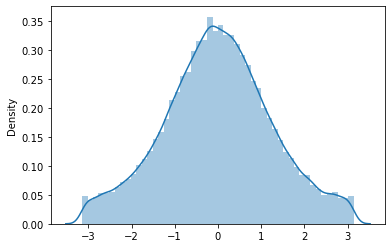

In [38]:
simulation_metropolis(3, kappa=1, mu=0,  N=100_000)

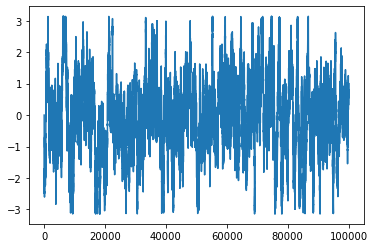

In [19]:
plt.plot(x)

C:\Users\elisa\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


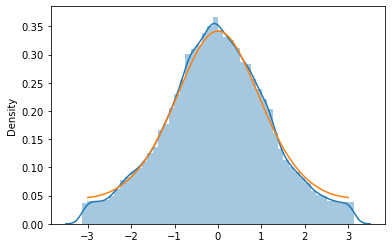

In [20]:
sns.distplot(x)
from scipy import stats
xx = np.linspace(-3,3, 1000)
plt.plot(xx, vonmises.pdf(xx, kappa, mu))

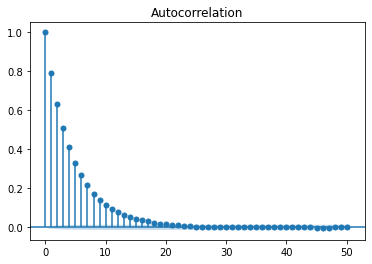

In [234]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(x)

plt.show()